# Physics-Informed Machine Learning
s194353, s194326, s194317, s194330, s194318 \\
A. Schou, A. Borup, M. Carøe, L. Nicolaisen, V. Hansen

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mse = torch.nn.MSELoss()

import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.nn.parameter import Parameter

import random
import time

import matplotlib
import matplotlib.pyplot as plt


import scipy
import scipy.special
import scipy.integrate

c2=1.4**2 #wave speed

# Physics-Informed Neural Networks (PINNs)

In [2]:
#Auxiliary functions to compute loss and true solution + softadapt to adjust the weights of the loss function.
def initial(x,y): #PDE IC, for the PINN we have to train for one specific intitial condition
  return torch.exp(-(((x-0.5)/0.2)**2))

def dinitial(x,y): #Second IC, time-derivative
  return 0*x

def PINNLOSS(x,y,net): # PDE-loss
  u = net(x,y)
  u_x = torch.autograd.grad(u.sum(), x, create_graph = True)[0]
  u_y = torch.autograd.grad(u.sum(), y, create_graph = True)[0]
  u_xx = torch.autograd.grad(u_x.sum(), x, create_graph = True)[0]
  u_yy = torch.autograd.grad(u_y.sum(), y, create_graph = True)[0]  
  return u_yy - 1.4**2*u_xx

def BOUNDARYLOSS(x,y,net): #BC-LOSS
  u = net(x,y)
  u_x = torch.autograd.grad(u.sum(), x, create_graph = True)[0]
  return u_x

def DINITIALLOSS(x,y,net): #IC-LOSS of time-derivative
  u = net(x,y)
  u_y = torch.autograd.grad(u.sum(), y, create_graph = True)[0]
  return u_y


def softadapt(mse_pinn, mse_bc0, mse_bc1, mse_ic0, mse_ic1, mse_pinnprev, mse_bc0prev, mse_bc1prev, mse_ic0prev, mse_ic1prev):
  pinn = mse_pinn.cpu().detach().numpy()
  bc0 = mse_bc0.cpu().detach().numpy()
  bc1 = mse_bc1.cpu().detach().numpy()
  ic0 = mse_ic0.cpu().detach().numpy()
  ic1 = mse_ic1.cpu().detach().numpy()
  pinnprev = mse_pinnprev.cpu().detach().numpy()
  bc0prev = mse_bc0prev.cpu().detach().numpy()
  bc1prev = mse_bc1prev.cpu().detach().numpy()
  ic0prev = mse_ic0prev.cpu().detach().numpy()
  ic1prev = mse_ic1prev.cpu().detach().numpy()

  epinn = np.exp(0.1 * (pinn - np.max([pinn, pinnprev])))
  ebc0 = np.exp(0.1 * (bc0 - np.max([bc0, bc0prev])))
  ebc1 = np.exp(0.1 * (bc1 - np.max([bc1, bc1prev])))
  eic0 = np.exp(0.1 * (ic0 - np.max([ic0, ic0prev])))
  eic1 = np.exp(0.1 * (ic1 - np.max([ic1, ic1prev])))

  etotal = epinn + ebc0 + ebc1 + eic0 + eic1 + 1e-8 

  alphapinn = epinn/etotal
  alphabc0 = ebc0/etotal
  alphabc1 = ebc1/etotal
  alphaic0 = eic0/etotal
  alphaic1 = eic1/etotal

  alphatotal = pinn*alphapinn + bc0*alphabc0 + bc1*alphabc1 + ic0*alphaic0 + ic1*alphaic1 + 1e-8

  lambdapinn = pinn*alphapinn/(alphatotal + 1e-8)
  lambdabc0 = bc0*alphabc0/(alphatotal + 1e-8)
  lambdabc1 = bc1*alphabc1/(alphatotal + 1e-8)
  lambdaic0 = ic0*alphaic0/(alphatotal + 1e-8)
  lambdaic1 = ic1*alphaic1/(alphatotal + 1e-8)

  return lambdapinn, lambdabc0, lambdabc1, lambdaic0, lambdaic1

In [3]:
# Defining the PINN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,32)
        self.hidden_layer2 = nn.Linear(32,32)
        self.output_layer = nn.Linear(32,1)
        self.activation = torch.nn.Tanh()

    def forward(self, x,t):
        inputs = torch.transpose(torch.stack([x,t]),0,1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = self.activation(self.hidden_layer1(inputs))
        layer2_out = self.activation(self.hidden_layer2(layer1_out))
        output = self.output_layer(layer2_out) ## For regression, no activation is used in output layer
        return output

In [4]:
#Data generation
num_colloc = 10000 #Collocation points inside the domain
num_bc = 2000 #Points on the poundary

xvals = [-1, 1]
yvals = [0, 1]

x_COLLOC = torch.rand(num_colloc)*(xvals[1]-xvals[0])+xvals[0] #uniformly distributed points
y_COLLOC = torch.rand(num_colloc)*(yvals[1]-yvals[0])+yvals[0]

x_IC = torch.rand(num_bc)*(xvals[1]-xvals[0])+xvals[0]
x_BC1 = torch.ones(num_bc)*xvals[0]
x_BC2 = torch.ones(num_bc)*xvals[1]

y_IC = torch.ones(num_bc)*yvals[0]
y_BC1 = torch.rand(num_bc)*(yvals[1]-yvals[0])+yvals[0]
y_BC2 = torch.rand(num_bc)*(yvals[1]-yvals[0])+yvals[0]

u_IC = initial(x_IC, y_IC)
u_dIC = dinitial(x_IC, y_IC)
u_BC1 = dinitial(x_BC1, y_BC1)
u_BC2 = dinitial(x_BC2, y_BC2)

In [5]:
net = Net() #Create the PINN
net = net.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 2000])) that is different to the input size (torch.Size([2000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 10000])) that is different to the input size (torch.Size([10000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=ob

Epoch  1 : Train Loss 0.132292
Epoch 5001 : Train Loss 0.000835
Epoch 10001 : Train Loss 0.000347
Epoch 15001 : Train Loss 0.000242
Epoch 20001 : Train Loss 0.000184
Epoch 25001 : Train Loss 0.000151
Epoch 30001 : Train Loss 0.000123
Epoch 35001 : Train Loss 0.000101
Epoch 40001 : Train Loss 0.000082
Epoch 45001 : Train Loss 0.000069
Epoch  1 : Train Loss 0.000060
Epoch 5001 : Train Loss 0.000043
Epoch 10001 : Train Loss 0.000037
Epoch 15001 : Train Loss 0.000032
Epoch 20001 : Train Loss 0.000030
Epoch 25001 : Train Loss 0.000028
Epoch 30001 : Train Loss 0.000026
Epoch 35001 : Train Loss 0.000024
Epoch 40001 : Train Loss 0.000022
Epoch 45001 : Train Loss 0.000020
Epoch  1 : Train Loss 0.000018
Epoch 5001 : Train Loss 0.000016
Epoch 10001 : Train Loss 0.000013
Epoch 15001 : Train Loss 0.000010
Epoch 20001 : Train Loss 0.000008


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Loss'))

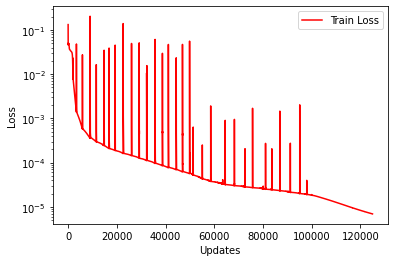

In [6]:
#Training
LR = [1e-3, 1e-4, 1e-5] #Adaptive learning rate
EP = [50000, 50000, 25000]    

losses=[] #store the losses

x=np.arange(-1,1,0.02)
y=np.arange(0,1,0.02)
ms_x, ms_y = np.meshgrid(x, y)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
y = np.ravel(ms_y).reshape(-1,1)

pt_x = Variable(torch.flatten(torch.from_numpy(x).float()), requires_grad=True).to(device)
pt_y = Variable(torch.flatten(torch.from_numpy(y).float()), requires_grad=True).to(device)

for iterations, lr in zip(EP,LR): #Training loop
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  previous_validation_loss = 99999999.0
  mse_f_prev = torch.zeros(1).to(device).to(device)
  mse_bc1_prev = torch.zeros(1).to(device).to(device)
  mse_bc2_prev = torch.zeros(1).to(device).to(device)
  mse_ic_prev = torch.zeros(1).to(device).to(device)
  mse_dic_prev = torch.zeros(1).to(device).to(device)

  for epoch in range(iterations):
      optimizer.zero_grad() # to make the gradients zero
      
      # Loss based on boundary conditions
      pt_x_ic = Variable((x_IC).float(), requires_grad=False).to(device)
      pt_y_ic = Variable((y_IC).float(), requires_grad=False).to(device)
      pt_u_ic = Variable((u_IC).float(), requires_grad=False).to(device)

      pt_x_dic = Variable((x_IC).float(), requires_grad=True).to(device)
      pt_y_dic = Variable((y_IC).float(), requires_grad=True).to(device)

      pt_x_bc1 = Variable((x_BC1).float(), requires_grad=True).to(device)
      pt_y_bc1 = Variable((y_BC1).float(), requires_grad=True).to(device)

      pt_x_bc2 = Variable((x_BC2).float(), requires_grad=True).to(device)
      pt_y_bc2 = Variable((y_BC2).float(), requires_grad=True).to(device)
      
      all_zeros_bc = torch.zeros((1, num_bc))
      all_zeros_colloc = torch.zeros((1, num_colloc))
      
      pt_x_collocation = Variable((x_COLLOC).float(), requires_grad=True).to(device)
      pt_y_collocation = Variable((y_COLLOC).float(), requires_grad=True).to(device)
      
      pt_all_zeros_bc = Variable((all_zeros_bc).float(), requires_grad=False).to(device)
      pt_all_zeros_colloc = Variable((all_zeros_colloc).float(), requires_grad=False).to(device)

      net_ic_out = torch.ravel(net(pt_x_ic, pt_y_ic))

      mse_ic = mse_cost_function(net_ic_out, pt_u_ic)

      dic_out = torch.ravel(DINITIALLOSS(pt_x_dic, pt_y_dic, net))
      mse_dic = mse_cost_function(dic_out, pt_all_zeros_bc)

      bc1_out = torch.ravel(BOUNDARYLOSS(pt_x_bc1, pt_y_bc1, net))
      mse_bc1 = mse_cost_function(bc1_out, pt_all_zeros_bc)
      
      bc2_out = torch.ravel(BOUNDARYLOSS(pt_x_bc2, pt_y_bc2, net))
      mse_bc2 = mse_cost_function(bc2_out, pt_all_zeros_bc)

      f_out = torch.ravel(PINNLOSS(pt_x_collocation, pt_y_collocation, net))
      mse_f = mse_cost_function(f_out, pt_all_zeros_colloc)
      
      # Combining the loss functions
      lambdaf, lambdabc1, lambdabc2, lambdaic, lambdadic = softadapt(mse_f, mse_bc1, mse_bc2, mse_ic, mse_dic, mse_f_prev, mse_bc1_prev, mse_bc2_prev, mse_ic_prev, mse_dic_prev)
      loss = lambdaic*mse_ic + lambdadic*mse_dic + lambdabc1*mse_bc1 + lambdabc2*mse_bc2 + lambdaf*mse_f    
      mse_f_prev = mse_f 
      mse_bc1_prev = mse_bc1
      mse_bc2_prev = mse_bc2
      mse_ic_prev = mse_ic
      mse_dic_prev = mse_dic
      
      loss.backward()
      optimizer.step()

      losses.append(float(loss))

      if epoch % 5000 == 0:
                  print("Epoch %2i : Train Loss %f" % (
                  epoch+1, losses[-1]))


epoch = np.arange(len(losses))
plt.figure()
plt.semilogy(epoch, losses, 'r')
plt.legend(['Train Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')


          

In [7]:
#Two initial conditions PINN
def initial(x,y):
  return torch.exp(-(((x-0.5)/0.2)**2)) + torch.exp(-(((x+0.1)/0.2)**2))

def dinitial(x,y):
  return 0*x

def PINNLOSS(x,y,net):
  u = net(x,y)
  u_x = torch.autograd.grad(u.sum(), x, create_graph = True)[0]
  u_y = torch.autograd.grad(u.sum(), y, create_graph = True)[0]
  u_xx = torch.autograd.grad(u_x.sum(), x, create_graph = True)[0]
  u_yy = torch.autograd.grad(u_y.sum(), y, create_graph = True)[0]  
  return u_yy - 1.4**2*u_xx

def BOUNDARYLOSS(x,y,net):
  u = net(x,y)
  u_x = torch.autograd.grad(u.sum(), x, create_graph = True)[0]
  return u_x

def DINITIALLOSS(x,y,net):
  u = net(x,y)
  u_y = torch.autograd.grad(u.sum(), y, create_graph = True)[0]
  return u_y


def softadapt(mse_pinn, mse_bc0, mse_bc1, mse_ic0, mse_ic1, mse_pinnprev, mse_bc0prev, mse_bc1prev, mse_ic0prev, mse_ic1prev):
  pinn = mse_pinn.cpu().detach().numpy()
  bc0 = mse_bc0.cpu().detach().numpy()
  bc1 = mse_bc1.cpu().detach().numpy()
  ic0 = mse_ic0.cpu().detach().numpy()
  ic1 = mse_ic1.cpu().detach().numpy()
  pinnprev = mse_pinnprev.cpu().detach().numpy()
  bc0prev = mse_bc0prev.cpu().detach().numpy()
  bc1prev = mse_bc1prev.cpu().detach().numpy()
  ic0prev = mse_ic0prev.cpu().detach().numpy()
  ic1prev = mse_ic1prev.cpu().detach().numpy()

  epinn = np.exp(0.1 * (pinn - np.max([pinn, pinnprev])))
  ebc0 = np.exp(0.1 * (bc0 - np.max([bc0, bc0prev])))
  ebc1 = np.exp(0.1 * (bc1 - np.max([bc1, bc1prev])))
  eic0 = np.exp(0.1 * (ic0 - np.max([ic0, ic0prev])))
  eic1 = np.exp(0.1 * (ic1 - np.max([ic1, ic1prev])))

  etotal = epinn + ebc0 + ebc1 + eic0 + eic1 + 1e-8 

  alphapinn = epinn/etotal
  alphabc0 = ebc0/etotal
  alphabc1 = ebc1/etotal
  alphaic0 = eic0/etotal
  alphaic1 = eic1/etotal

  alphatotal = pinn*alphapinn + bc0*alphabc0 + bc1*alphabc1 + ic0*alphaic0 + ic1*alphaic1 + 1e-8

  lambdapinn = pinn*alphapinn/(alphatotal + 1e-8)
  lambdabc0 = bc0*alphabc0/(alphatotal + 1e-8)
  lambdabc1 = bc1*alphabc1/(alphatotal + 1e-8)
  lambdaic0 = ic0*alphaic0/(alphatotal + 1e-8)
  lambdaic1 = ic1*alphaic1/(alphatotal + 1e-8)

  return lambdapinn, lambdabc0, lambdabc1, lambdaic0, lambdaic1


In [8]:
#Data generation
num_colloc = 10000
num_bc = 2000

xvals = [-1, 1]
yvals = [0, 1]

x_COLLOC = torch.rand(num_colloc)*(xvals[1]-xvals[0])+xvals[0]
y_COLLOC = torch.rand(num_colloc)*(yvals[1]-yvals[0])+yvals[0]

x_IC = torch.rand(num_bc)*(xvals[1]-xvals[0])+xvals[0]
x_BC1 = torch.ones(num_bc)*xvals[0]
x_BC2 = torch.ones(num_bc)*xvals[1]

y_IC = torch.ones(num_bc)*yvals[0]
y_BC1 = torch.rand(num_bc)*(yvals[1]-yvals[0])+yvals[0]
y_BC2 = torch.rand(num_bc)*(yvals[1]-yvals[0])+yvals[0]

u_IC = initial(x_IC, y_IC)
u_dIC = dinitial(x_IC, y_IC)
u_BC1 = dinitial(x_BC1, y_BC1)
u_BC2 = dinitial(x_BC2, y_BC2)

In [9]:
net2 = Net() #Second network for the different IC's
net2 = net2.to(device)
mse_cost_function = torch.nn.MSELoss() # Mean squared error

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 2000])) that is different to the input size (torch.Size([2000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 10000])) that is different to the input size (torch.Size([10000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=ob

Epoch  1 : Train Loss 0.258547
Epoch 5001 : Train Loss 0.003698
Epoch 10001 : Train Loss 0.000496
Epoch 15001 : Train Loss 0.000268
Epoch 20001 : Train Loss 0.000441
Epoch 25001 : Train Loss 0.000133
Epoch 30001 : Train Loss 0.000105
Epoch 35001 : Train Loss 0.000085
Epoch 40001 : Train Loss 0.000074
Epoch 45001 : Train Loss 0.000058
Epoch  1 : Train Loss 0.000050
Epoch 5001 : Train Loss 0.000038
Epoch 10001 : Train Loss 0.000032
Epoch 15001 : Train Loss 0.000028
Epoch 20001 : Train Loss 0.000025
Epoch 25001 : Train Loss 0.000023
Epoch 30001 : Train Loss 0.000021
Epoch 35001 : Train Loss 0.000019
Epoch 40001 : Train Loss 0.000018
Epoch 45001 : Train Loss 0.000017
Epoch  1 : Train Loss 0.000015
Epoch 5001 : Train Loss 0.000013
Epoch 10001 : Train Loss 0.000012
Epoch 15001 : Train Loss 0.000011
Epoch 20001 : Train Loss 0.000010


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Loss'))

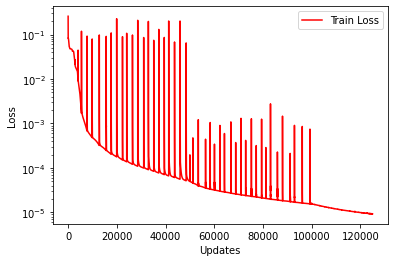

In [ ]:
#Training second netowrk
LR = [1e-3, 1e-4, 1e-5]   
EP = [50000, 50000, 25000]    
losses=[]   

x=np.arange(-1,1,0.02)
y=np.arange(0,1,0.02)
ms_x, ms_y = np.meshgrid(x, y)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
y = np.ravel(ms_y).reshape(-1,1)

pt_x = Variable(torch.flatten(torch.from_numpy(x).float()), requires_grad=True).to(device)
pt_y = Variable(torch.flatten(torch.from_numpy(y).float()), requires_grad=True).to(device)

for iterations, lr in zip(EP,LR):
  optimizer = torch.optim.Adam(net2.parameters(), lr=lr)
  previous_validation_loss = 99999999.0
  mse_f_prev = torch.zeros(1).to(device)
  mse_bc1_prev = torch.zeros(1).to(device)
  mse_bc2_prev = torch.zeros(1).to(device)
  mse_ic_prev = torch.zeros(1).to(device)
  mse_dic_prev = torch.zeros(1).to(device)

  for epoch in range(iterations):
      optimizer.zero_grad() # to make the gradients zero
      
      # Loss based on boundary conditions
      pt_x_ic = Variable((x_IC).float(), requires_grad=False).to(device)
      pt_y_ic = Variable((y_IC).float(), requires_grad=False).to(device)
      pt_u_ic = Variable((u_IC).float(), requires_grad=False).to(device)

      pt_x_dic = Variable((x_IC).float(), requires_grad=True).to(device)
      pt_y_dic = Variable((y_IC).float(), requires_grad=True).to(device)

      pt_x_bc1 = Variable((x_BC1).float(), requires_grad=True).to(device)
      pt_y_bc1 = Variable((y_BC1).float(), requires_grad=True).to(device)

      pt_x_bc2 = Variable((x_BC2).float(), requires_grad=True).to(device)
      pt_y_bc2 = Variable((y_BC2).float(), requires_grad=True).to(device)
      
      all_zeros_bc = torch.zeros((1, num_bc))
      all_zeros_colloc = torch.zeros((1, num_colloc))
      
      pt_x_collocation = Variable((x_COLLOC).float(), requires_grad=True).to(device)
      pt_y_collocation = Variable((y_COLLOC).float(), requires_grad=True).to(device)
      
      pt_all_zeros_bc = Variable((all_zeros_bc).float(), requires_grad=False).to(device)
      pt_all_zeros_colloc = Variable((all_zeros_colloc).float(), requires_grad=False).to(device)

      net2_ic_out = torch.ravel(net2(pt_x_ic, pt_y_ic))

      mse_ic = mse_cost_function(net2_ic_out, pt_u_ic)

      dic_out = torch.ravel(DINITIALLOSS(pt_x_dic, pt_y_dic, net2))
      mse_dic = mse_cost_function(dic_out, pt_all_zeros_bc)

      bc1_out = torch.ravel(BOUNDARYLOSS(pt_x_bc1, pt_y_bc1, net2))
      mse_bc1 = mse_cost_function(bc1_out, pt_all_zeros_bc)
      
      bc2_out = torch.ravel(BOUNDARYLOSS(pt_x_bc2, pt_y_bc2, net2))
      mse_bc2 = mse_cost_function(bc2_out, pt_all_zeros_bc)

      f_out = torch.ravel(PINNLOSS(pt_x_collocation, pt_y_collocation, net2))
      mse_f = mse_cost_function(f_out, pt_all_zeros_colloc)
      
      # Combining the loss functions
      lambdaf, lambdabc1, lambdabc2, lambdaic, lambdadic = softadapt(mse_f, mse_bc1, mse_bc2, mse_ic, mse_dic, mse_f_prev, mse_bc1_prev, mse_bc2_prev, mse_ic_prev, mse_dic_prev)
      loss = lambdaic*mse_ic + lambdadic*mse_dic + lambdabc1*mse_bc1 + lambdabc2*mse_bc2 + lambdaf*mse_f    
      mse_f_prev = mse_f 
      mse_bc1_prev = mse_bc1
      mse_bc2_prev = mse_bc2
      mse_ic_prev = mse_ic
      mse_dic_prev = mse_dic
      
      loss.backward()
      optimizer.step()

      losses.append(float(loss))

      if epoch % 5000 == 0:
                  print("Epoch %2i : Train Loss %f" % (
                  epoch+1, losses[-1]))


epoch = np.arange(len(losses))
plt.figure()
plt.semilogy(epoch, losses, 'r')
plt.legend(['Train Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')

# Physics-Informed DeepOnet

In [24]:
#Functions to generate initial conditions from Gaussian Random Field
def RBF(x1, x2, params): #Variance kernel
    output_scale, lengthscales = params
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

def generate_function(length_scale):
    xmin=-1
    xmax=1

    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = np.linspace(xmin, xmax, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N)) #Cholesky to obtain the correct Variance
    gp_sample = np.dot(L, np.random.normal(0,1,(N,)))
    # Create a callable interpolation function  
    f_fn = lambda x: np.interp(x, X.flatten(), gp_sample)

    return f_fn

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Data generation
P=300 #Boundary points per function
Q=100 #Collocation points per function
N=5000 #Number of functions
m=100 #Number of sensors
 
length_scale=0.2 #Parameter in our Radial Basis Function

x_sensor=np.linspace(-1,1,m) #Sensors for the branch network

x_ic=np.random.rand(N*(P // 3),1)*2-1 
u=torch.zeros(N,P // 3)
u_ic=torch.zeros(N*(P //3),1,requires_grad=False, device=device)

for i in range(N):
  f_fn=generate_function(length_scale)
  u[i,:]=torch.tensor(f_fn(x_sensor)).to(device)
  u_ic[i*(P//3):(i+1)*(P//3)]=torch.Tensor(f_fn(x_ic[i*(P//3):(i+1)*(P//3)])).to(device)

u=torch.repeat_interleave(u,Q,0).to(device)
x_ic=torch.tensor(np.float32(x_ic),device=device)

Using device: cuda


In [26]:
class Net(nn.Module): #Branch network class
    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  

        # input layer
        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden[0], m)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden[0]), 0))
        # hidden layer
        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden[1], num_hidden[0])))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden[1]), 0))

        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden[2], num_hidden[1])))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_hidden[2]), 0))

        self.W_4 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden[2])))
        self.b_4 = Parameter(init.constant_(torch.Tensor(num_output), 0))
      
        self.activation = torch.nn.Tanh()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)

        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x)

        x = F.linear(x, self.W_3, self.b_3)
        x = self.activation(x)

        x = F.linear(x, self.W_4, self.b_4)
        return x


class Net2(nn.Module): #Trunk network class with activation function before output
    def __init__(self, num_features, num_hidden, num_output):
        super(Net2, self).__init__()  

        self.W_1 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden[0], num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden[0]), 0))

        self.W_2 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden[1], num_hidden[0])))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden[1]), 0))

        self.W_3 = Parameter(init.xavier_normal_(torch.Tensor(num_hidden[2], num_hidden[1])))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_hidden[2]), 0))
        
        self.W_4 = Parameter(init.xavier_normal_(torch.Tensor(num_output, num_hidden[2])))
        self.b_4 = Parameter(init.constant_(torch.Tensor(num_output), 0))

        self.activation = torch.nn.Tanh()

    def forward(self, x,t):
        x=torch.cat([x,t],axis=1)

        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)

    
        x = F.linear(x, self.W_2, self.b_2)
        x = self.activation(x)

        x = F.linear(x, self.W_3, self.b_3)
        x = self.activation(x)

        x = F.linear(x, self.W_4, self.b_4)
        x = self.activation(x)
        return x

branch = Net(m, [64,64,64], 64).to(device)
trunk = Net2(2, [64,64,64], 64).to(device)

params = list(branch.parameters()) + list(trunk.parameters())

def DeepOnet(u,x,t): #Function to compute a forward pass of the DeepONet
  return torch.sum(branch(u)*trunk(x,t),1)[:,None]


def df(output: torch.Tensor, input: torch.Tensor, order: int = 1) -> torch.Tensor: #Auxilliary function to compute derivatives
  """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
  df_value = output
  for _ in range(order):
      df_value = torch.autograd.grad(
          df_value,
          input,
          grad_outputs=torch.ones_like(input),
          create_graph=True,
          retain_graph=True,
      )[0]

  return df_value

def loss_fn(x_int,x_ic,x_bc1,x_bc2,    t_int,t_ic   ,  u_ic   ,output_int,output_ic,output_bc1, output_bc2, ii): #Physics-Informed Loss

  #Initial condition loss
  icd=df(output_ic, t_ic,1)
  
  loss_ic1=mse( output_ic, u_ic[ii]) 
  loss_ic2=mse(icd,torch.zeros_like(icd))
  
  #Boundary condition loss
  bcd1=df(output_bc1, x_bc1,1)
  bcd2=df(output_bc2, x_bc2,1)

  loss_bc1=mse(bcd1,torch.zeros_like(bcd1))
  loss_bc2=mse(bcd2,torch.zeros_like(bcd2))

  #PDE loss
  dx2=df(output_int, x_int, 2)
  dt2=df(output_int, t_int, 2)

  loss_pde = mse(dt2, c2*dx2)
  
  return loss_ic1+loss_ic2+2*loss_pde+loss_bc1+loss_bc2


Epoch  1 : Train Loss 0.874589
Epoch 201 : Train Loss 0.270869
Epoch 401 : Train Loss 0.162316
Epoch 601 : Train Loss 0.104345
Epoch 801 : Train Loss 0.093646
Epoch 1001 : Train Loss 0.083772
Epoch 1201 : Train Loss 0.060981
Epoch 1401 : Train Loss 0.057416
Epoch 1601 : Train Loss 0.053215
Epoch 1801 : Train Loss 0.051586
Epoch 2001 : Train Loss 0.049292
Epoch 2201 : Train Loss 0.050094
Epoch 2401 : Train Loss 0.050629
Epoch 2601 : Train Loss 0.048132
Epoch 2801 : Train Loss 0.047780
Epoch 3001 : Train Loss 0.047379
Epoch 3201 : Train Loss 0.047011
Epoch 3401 : Train Loss 0.046594
Epoch 3601 : Train Loss 0.045925
Epoch 3801 : Train Loss 0.044804
Epoch 4001 : Train Loss 0.042693
Epoch 4201 : Train Loss 0.038982
Epoch 4401 : Train Loss 0.035326
Epoch 4601 : Train Loss 0.033134
Epoch 4801 : Train Loss 0.031922


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Loss'))

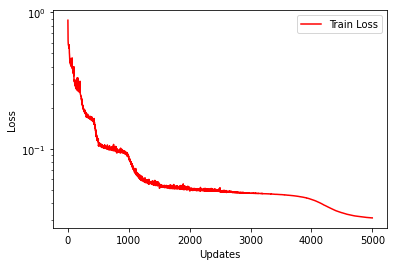

In [27]:
#Training loop
num_epochs=5000
losses=[]

batch_size=10000
num_batches=N*Q // batch_size

#Data for each batch
x_bc1=-torch.ones(batch_size,1,requires_grad=True, device=device)
x_bc2=torch.ones(batch_size,1,requires_grad=True, device=device)
t_ic=torch.zeros(batch_size,1,requires_grad=True, device=device)

branch.train()
trunk.train()

optimizer = optim.Adam(params, lr=1e-3,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,500,800,1000,1500,2000,2500,2600,2700,2800,2900,3000,3200,3400,3600,3800,4000,4200,4400,4600,4700,4800,4900], gamma=0.8)
for epoch in range(num_epochs):
	losssave=0
	idx=torch.randperm(N*Q) #create batches
	for i in range(num_batches):
		ii=idx[i*batch_size:(i+1)*batch_size]
		x_int=torch.tensor(np.float32(np.random.rand(batch_size,1)*2-1),requires_grad=True, device=device)
		t_int=torch.rand(batch_size,1,requires_grad=True, device=device)
		t_bc1=torch.rand(batch_size,1,requires_grad=False, device=device)
		t_bc2=torch.rand(batch_size,1,requires_grad=False, device=device)

		output_int = DeepOnet(u[ii,:],x_int,t_int)
		output_ic = DeepOnet(u[ii,:],x_ic[ii,:],t_ic)
		output_bc1 = DeepOnet(u[ii,:],x_bc1,t_bc1)
		output_bc2 = DeepOnet(u[ii,:],x_bc2,t_bc1)

		loss = loss_fn(x_int,x_ic,x_bc1,x_bc2,    t_int,t_ic   ,  u_ic   ,output_int,output_ic,output_bc1, output_bc2, ii)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()   
		losssave+=loss

	losses.append(float(losssave/num_batches))
	scheduler.step()

	if epoch % 200 == 0:
		print("Epoch %2i : Train Loss %f" % (
			   epoch+1, losses[-1]))


epoch = np.arange(len(losses))
plt.figure()
plt.semilogy(epoch, losses, 'r')
plt.legend(['Train Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')

# Data-driven DeepOnet




In [13]:
#Auxilliary functions to solve the PDEs numerically
def JacobiP(x,alpha,beta,n):
    if n == 0:
        P=np.ones(x.shape)
    else:
        P=0.5*(alpha-beta+(alpha+beta+2)*x)
        prev=np.ones(x.shape)

    for i in range(1,n):

        a=np.zeros((3,1))
        
        a[0]=2*(i+alpha)*(i+beta)/((2*i+alpha+beta+1)*(2*i+alpha+beta))
        a[1]=(alpha**2-beta**2)/((2*i+alpha+beta+2)*(2*i+alpha+beta))
        a[2]=2*(i+1)*(i+alpha+beta+1)/((2*i+alpha+beta+2)*(2*i+alpha+beta+1))

        temp=P;
        P=(a[1]+x)*P-a[0]*prev
        prev=temp
        P=P/a[2]

    return P

def GradJacobiP(x,alpha,beta,n):
    if n==0:
        P=np.zeros(x.shape)
    else:
        P=1/2*(alpha+beta+n+1)*JacobiP(x,alpha+1,beta+1,n-1);
    
    return P


def Vandermonde(x,alpha,beta,n):
    V=np.zeros((x.size,n+1));

    for j in range(0,n+1):
            V[:,j]=JacobiP(x,alpha,beta,j)
    return V

def VandermondeDerivative(x,alpha,beta,n):
    Vx=np.zeros((x.size,n+1))

    for j in range(0,n+1):
            Vx[:,j]=GradJacobiP(x,alpha,beta,j)
    return Vx

def JacobiGQ(alpha,beta,N):
    return scipy.special.roots_jacobi(N+1,alpha,beta)[0]

def JacobiGL(alpha,beta,N):
  x = np.zeros(N+1);
  if (N==1):
    x[1]=-1.0; x[2]=1.0
    return x
   
  xint = JacobiGQ(alpha+1,beta+1,N-2)
  x = np.concatenate(([-1], xint, [1]))
  return x

M=80
x=JacobiGL(0,0,M)
Vx=VandermondeDerivative(x,0,0,M)
V=Vandermonde(x,0,0,M)
Dx=Vx@np.linalg.inv(V)
def fun(t,UU):
  dx=Dx@UU[:M+1]
  dx[0]=0
  dx[-1]=0
  return np.concatenate([UU[M+1:], c2*Dx@dx])

In [14]:
#Data generation
Q=300
N=5000
m=100


x_int=np.zeros((N*Q,1))
t_int=np.zeros((N*Q,1))
u_int=np.zeros((N*Q,1))

x_sensor=np.linspace(-1,1,m)
u_sensor=np.zeros((N,m))

x_ic=np.zeros((N*Q,1))
t_ic=np.zeros((N*Q,1))
u_ic=np.zeros((N*Q,1))


length_scale=0.2

for i in range(N):
  f_fn=generate_function(length_scale)
  u_sensor[i,:]=f_fn(x_sensor)

  u=f_fn(x)
  UU=scipy.integrate.solve_ivp(fun, (0,1), np.concatenate([u,np.zeros(M+1)]), method='RK23') #Numerical solver

  x_idx=np.random.choice(np.arange(x.size),Q)
  t_idx=np.random.choice(np.arange(UU.t.size),Q)

  x_int[i*Q:(i+1)*Q]=x[x_idx].reshape(-1,1)
  t_int[i*Q:(i+1)*Q]=UU.t[t_idx].reshape(-1,1)

  u_int[i*Q:(i+1)*Q]=UU.y[:M+1,:][x_idx,t_idx].reshape(-1,1)

  x_ic[i*Q:(i+1)*Q]=np.random.rand(Q,1)*2-1
  u_ic[i*Q:(i+1)*Q]=f_fn(x_ic[i*Q:(i+1)*Q])


u_sensor=np.repeat(u_sensor,Q,0)
x_int=torch.tensor(np.float32(x_int),device=device)
t_int=torch.tensor(np.float32(t_int),device=device)
u_int=torch.tensor(np.float32(u_int),device=device)

u_sensor=torch.tensor(np.float32(u_sensor),device=device)

x_ic=torch.tensor(np.float32(x_ic),device=device)
t_ic=torch.tensor(np.float32(t_ic),device=device)
u_ic=torch.tensor(np.float32(u_ic),device=device)



In [15]:
branch2 = Net(m, [128,128,128], 128).to(device)
trunk2 = Net2(2, [128,128,128],128).to(device)

params = list(branch2.parameters()) + list(trunk2.parameters())

In [16]:
def DeepOnet2(u,x,t):
  return torch.sum(branch2(u)*trunk2(x,t),1)[:,None]

def loss_fn(output_int,u_int,output_ic,u_ic ):
  loss_int=mse(output_int,u_int) #Loss now is simply the MSE between the data and the output
  loss_ic=mse(output_ic,u_ic)
  
  return loss_int+loss_ic

Epoch  1 : Train Loss 0.992056
Epoch 101 : Train Loss 0.004095
Epoch 201 : Train Loss 0.002087
Epoch 301 : Train Loss 0.001799
Epoch 401 : Train Loss 0.001647
Epoch 501 : Train Loss 0.001587
Epoch 601 : Train Loss 0.001546
Epoch 701 : Train Loss 0.001516
Epoch 801 : Train Loss 0.001484
Epoch 901 : Train Loss 0.001461
Epoch 1001 : Train Loss 0.001443
Epoch 1101 : Train Loss 0.001426
Epoch 1201 : Train Loss 0.001417
Epoch 1301 : Train Loss 0.001404
Epoch 1401 : Train Loss 0.001395


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Loss'))

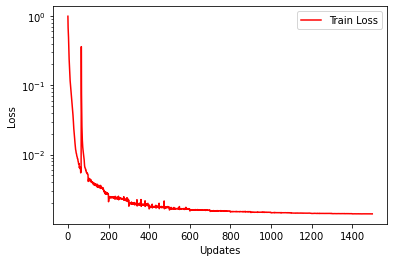

In [17]:
#Training
num_epochs = 1500
losses=[]
batch_size=10000
num_batches=N*Q // batch_size

branch2.train()
trunk2.train()

optimizer = optim.Adam(params, lr=1e-3,weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400], gamma=0.8)
for epoch in range(num_epochs):
      losssave=0
      idx=torch.randperm(N*Q)
      for i in range(num_batches):
        ii=idx[i*batch_size:(i+1)*batch_size]

        output_int = DeepOnet2(u_sensor[ii,:],x_int[ii],t_int[ii])
        output_ic = DeepOnet2(u_sensor[ii,:],x_ic[ii],t_ic[ii])

        loss = loss_fn(output_int,u_int[ii],output_ic,u_ic[ii])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()   

        losssave+=loss 

      losses.append(float(losssave/num_batches))
      scheduler.step()

      if epoch % 100 == 0:
          print("Epoch %2i : Train Loss %f" % (
                  epoch+1, losses[-1]))

epoch = np.arange(len(losses))
plt.figure()
plt.semilogy(epoch, losses, 'r')
plt.legend(['Train Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')

# Results

In [42]:
#from google.colab import drive
#drive.mount('/content/gdrive')


#net.load_state_dict(torch.load("/content/gdrive/My Drive/net.pt"))
#net2.load_state_dict(torch.load("/content/gdrive/My Drive/net2.pt"))

#branch.load_state_dict(torch.load("/content/gdrive/My Drive/PI-branchmodel.pt"))
#trunk.load_state_dict(torch.load("/content/gdrive/My Drive/PI-trunkmodel.pt"))


"""
path = F"/content/gdrive/My Drive/branch2.pt" 
torch.save(branch2.state_dict(), path)

path = F"/content/gdrive/My Drive/trunk2.pt" 
torch.save(branch2.state_dict(), path)

path = F"/content/gdrive/My Drive/net.pt" 
torch.save(net.state_dict(), path)

path = F"/content/gdrive/My Drive/net2.pt" 
torch.save(net2.state_dict(), path)
"""

'\npath = F"/content/gdrive/My Drive/branch2.pt" \ntorch.save(branch2.state_dict(), path)\n\npath = F"/content/gdrive/My Drive/trunk2.pt" \ntorch.save(branch2.state_dict(), path)\n\npath = F"/content/gdrive/My Drive/net.pt" \ntorch.save(net.state_dict(), path)\n\npath = F"/content/gdrive/My Drive/net2.pt" \ntorch.save(net2.state_dict(), path)\n'

In [19]:
def true_solution(XX, TT, xs=0.0, sigma=0.1, c=1.4):

    x1 = np.min(XX.ravel())
    x2 = np.max(XX.ravel())
    T = np.max(TT.ravel())
    
    

    d = x2-x1
    d1 = xs-x1
    d2 = x2-xs
    md = max(d1, d2)

    max_d = int(c*T // (2*d) + 4)


    def init_func(x, t, s):
        return 0.5*(np.exp(-((x-s-c*t)/sigma)**2)+np.exp(-((x-s+c*t)/sigma)**2))
    
    
    # Calculate solution from source position
    UU = init_func(XX, TT, xs)

    # Calculate artificial source positions
    ctr1 = [x2+d1+(2*m+1)*d for m in range(max_d)]
    ctr2 = [x2+d2+(2*m)*d for m in range(max_d)]
    ctl1 = [x1-(d1+(2*m)*d) for m in range(max_d)]
    ctl2 = [x1-(d2+(2*m+1)*d) for m in range(max_d)]
    
    # Calculate solutions from artificial source position
    for ct in [ctr1, ctr2, ctl1, ctl2]:
        for xi in ct:
            UU += init_func(XX, TT, xi)
    return UU

use_cuda = torch.cuda.is_available()
def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()   

#PINN

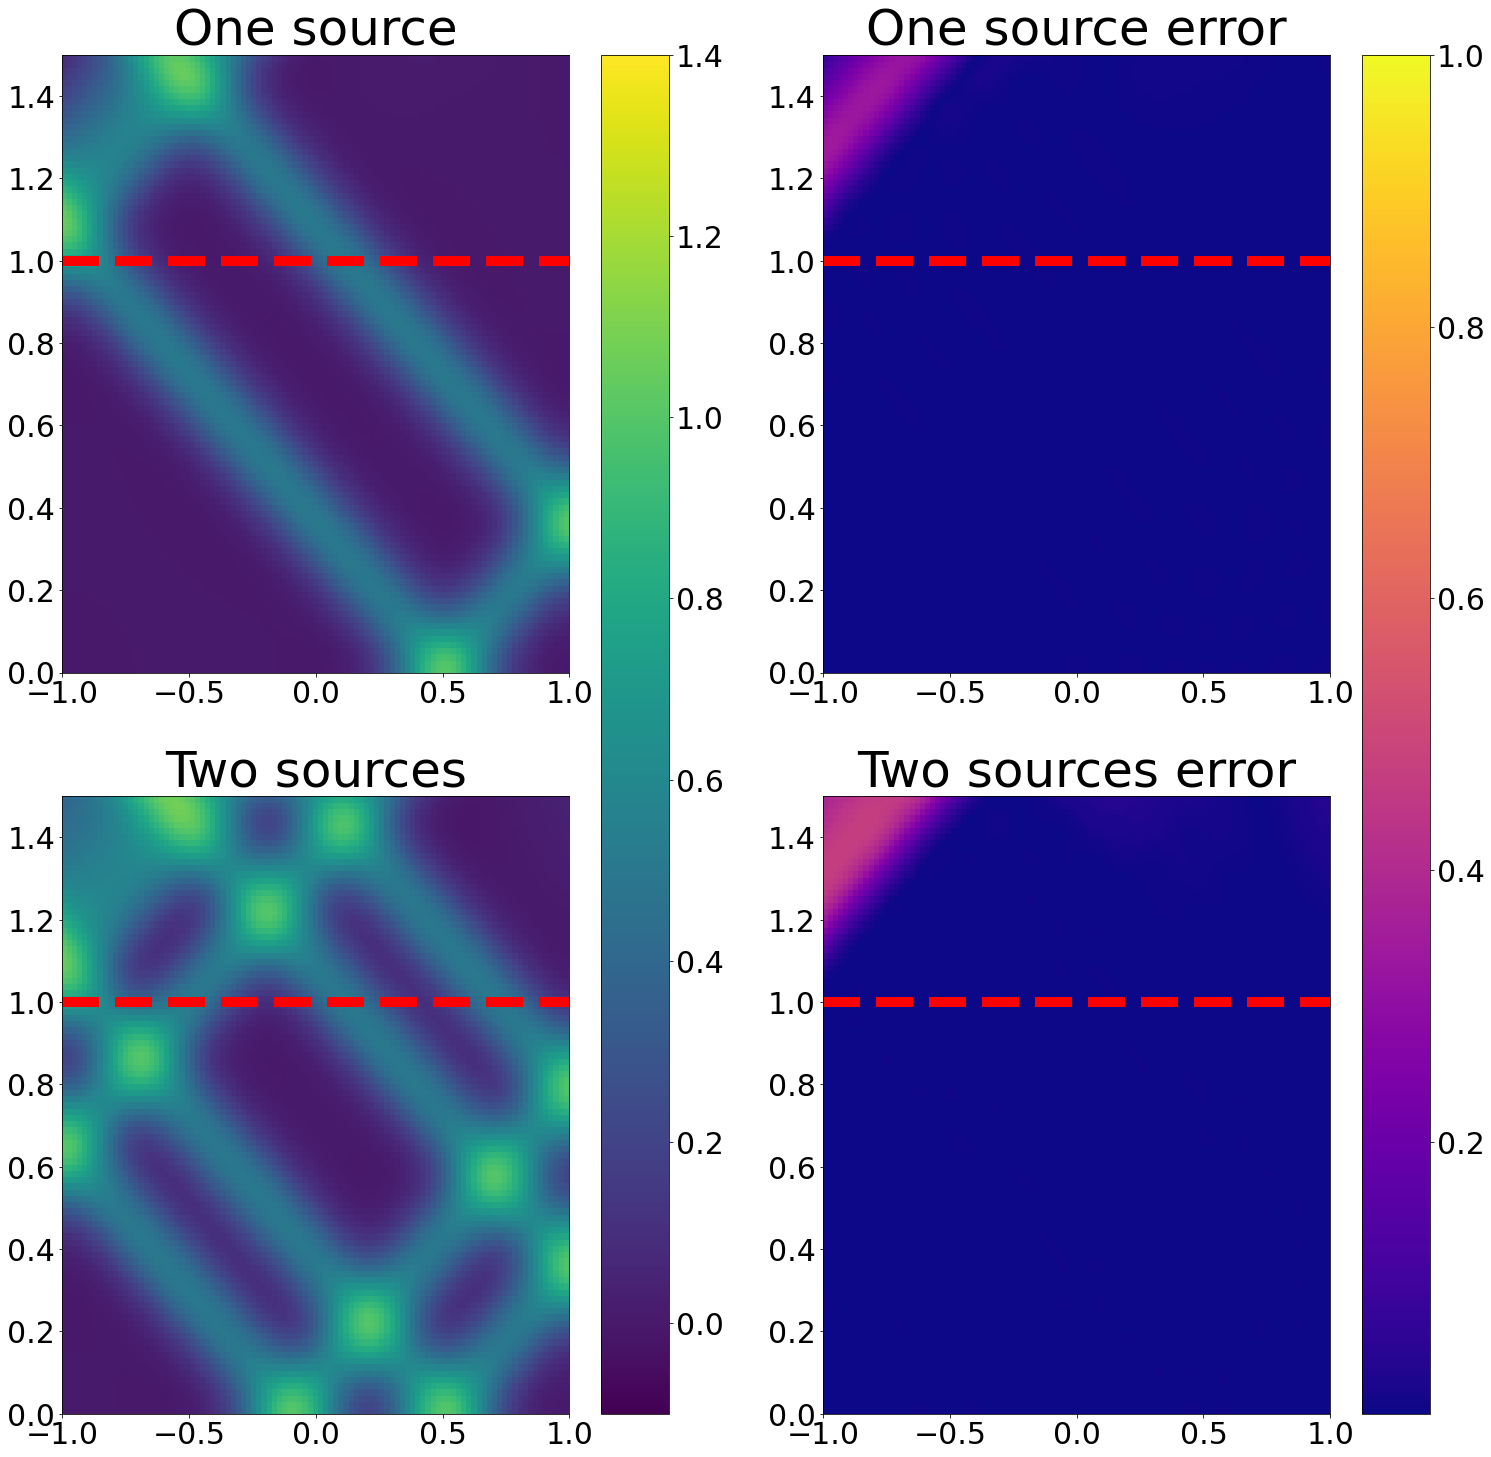

In [29]:
#Plotting output and error
fig, ax = plt.subplots(2,2, figsize=(25,25))

m = 100
x=np.linspace(-1,1,m)
y=np.linspace(0,1.5,m)
ms_x, ms_y = np.meshgrid(x, y)
x = np.ravel(ms_x).reshape(-1,1)
y = np.ravel(ms_y).reshape(-1,1)

pt_x = Variable(torch.flatten(torch.from_numpy(x).float()), requires_grad=True).to(device)
pt_y = Variable(torch.flatten(torch.from_numpy(y).float()), requires_grad=True).to(device)
pt_u = torch.ravel(net(pt_x, pt_y))

u_temp = pt_u.data.cpu().numpy()
ms_u = u_temp.reshape(ms_x.shape)

pt_u2 = torch.ravel(net2(pt_x, pt_y))

u2_temp = pt_u2.data.cpu().numpy()
ms_u2 = u2_temp.reshape(ms_x.shape)


p0=ax[0,0].pcolor(ms_x, ms_y, ms_u,vmax=1.4,vmin=-0.1)
ax[0,0].plot([-1, 1], [1,1], 'r--', linewidth=10)
ax[0,0].set_title(r'One source', fontsize=50)
ax[0,0].tick_params(axis='both', which='major', labelsize=30)


p1=ax[1,0].pcolor(ms_x, ms_y, ms_u2,vmax=1.4,vmin=-0.1)
ax[1,0].plot([-1, 1], [1,1], 'r--', linewidth=10)
ax[1,0].set_title(r'Two sources', fontsize=50)
ax[1,0].tick_params(axis='both', which='major', labelsize=30)

p2=ax[0,1].pcolor(ms_x, ms_y, abs(ms_u-true_solution(ms_x,ms_y,0.5,0.2,1.4)),vmax=1,cmap='plasma')
ax[0,1].plot([-1, 1], [1,1], 'r--', linewidth=10)
ax[0,1].set_title(r'One source error', fontsize=50)
ax[0,1].tick_params(axis='both', which='major', labelsize=30)

p3 = ax[1,1].pcolor(ms_x, ms_y, abs(ms_u2-true_solution(ms_x,ms_y,0.5,0.2,1.4) - true_solution(ms_x,ms_y,-0.1,0.2,1.4)),vmax=1,cmap='plasma')
ax[1,1].plot([-1, 1], [1,1], 'r--', linewidth=10)
ax[1,1].set_title(r'Two sources error', fontsize=50)
ax[1,1].tick_params(axis='both', which='major', labelsize=30)

c_ax1=fig.colorbar(p1,ax=ax[0:2,0])
c_ax3=fig.colorbar(p3,ax=ax[0:2,1])

ax[0,0].tick_params(axis='both', which='major', labelsize=30)
ax[1,0].tick_params(axis='both', which='major', labelsize=30)
ax[0,1].tick_params(axis='both', which='major', labelsize=30)
ax[1,1].tick_params(axis='both', which='major', labelsize=30)


c_ax1.ax.tick_params(labelsize=30)
c_ax3.ax.tick_params(labelsize=30)

plt.show()
fig.savefig("/content/gdrive/My Drive/PINN.png",transparent=True)


PI-DeepONet

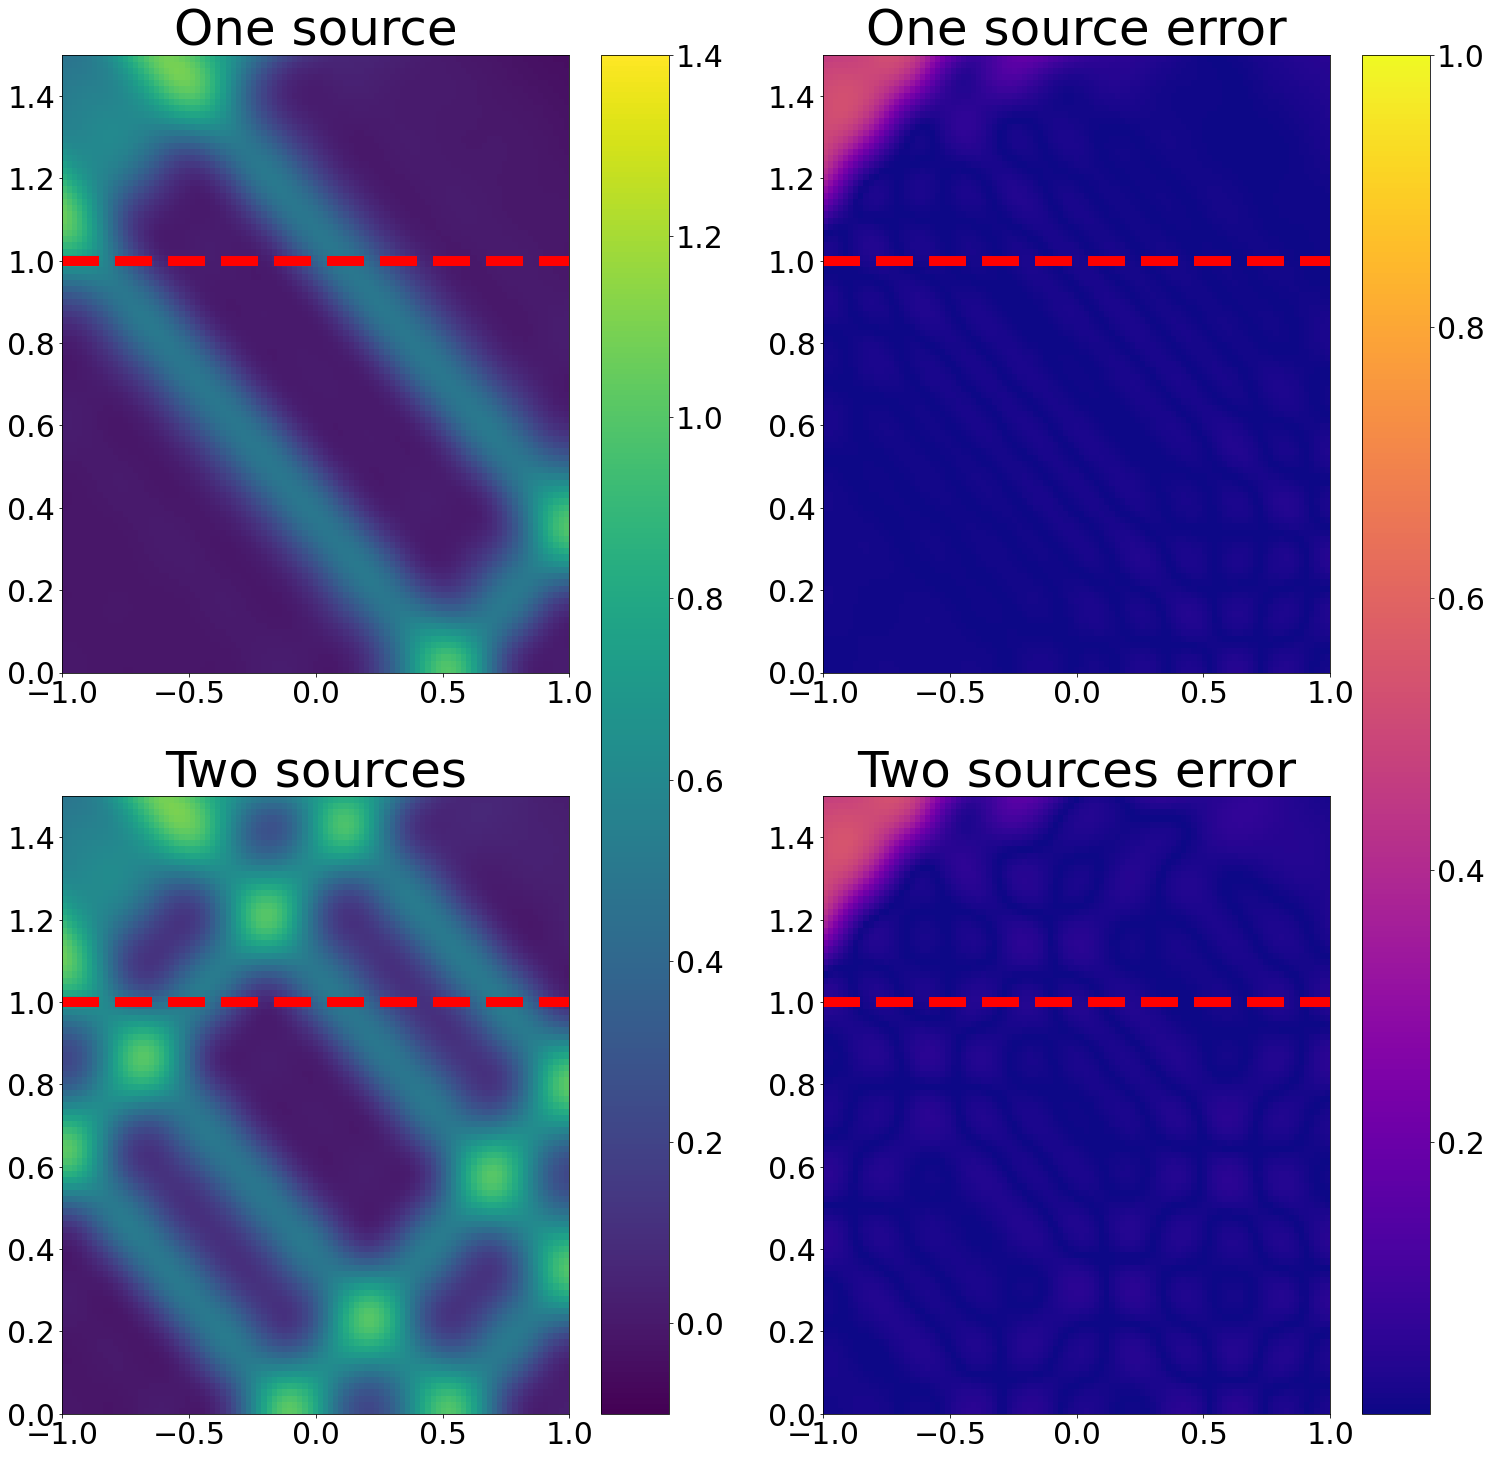

In [43]:
#Plotting output and error
fig, ax = plt.subplots(2,2, figsize=(25,25))

x=np.linspace(-1,1,m)
t=np.linspace(0,1.5,m)
uu=np.exp(-((x-0.5)/0.2)**2)

XX,TT=np.meshgrid(x,t)

Xtens=torch.tensor(np.float32(XX),device=device).reshape(-1)[:,None]
Ttens=torch.tensor(np.float32(TT),device=device).reshape(-1)[:,None]
 
uu=torch.tensor(np.float32(np.repeat(uu[:,None],m**2,1).T),device=device)
UU=DeepOnet(uu,Xtens,Ttens )
UU=get_numpy(UU).reshape(m,m)


uu2=np.exp(-((x+0.1)/0.2)**2)+np.exp(-((x-0.5)/0.2)**2)

uu2=torch.tensor(np.float32(np.repeat(uu2[:,None],m**2,1).T),device=device)
UU2=DeepOnet(uu2,Xtens,Ttens )
UU2=get_numpy(UU2).reshape(m,m)


p0=ax[0,0].pcolor(XX, TT, UU,vmax=1.4,vmin=-0.1)
ax[0,0].plot([-1, 1], [1,1], 'r--', linewidth=10)
ax[0,0].set_title(r'One source', fontsize=50)
ax[0,0].tick_params(axis='both', which='major', labelsize=30)


p1=ax[1,0].pcolor(XX, TT, UU2,vmax=1.4,vmin=-0.1)
ax[1,0].plot([-1, 1], [1,1], 'r--', linewidth=10)
ax[1,0].set_title(r'Two sources', fontsize=50)
ax[1,0].tick_params(axis='both', which='major', labelsize=30)

p2=ax[0,1].pcolor(XX, TT, np.abs(UU-true_solution(XX, TT,0.5,0.2,1.4)),vmax=1.0,cmap='plasma')
ax[0,1].plot([-1, 1], [1,1], 'r--', linewidth=10)
ax[0,1].set_title(r'One source error', fontsize=50)
ax[0,1].tick_params(axis='both', which='major', labelsize=30)

p3 = ax[1,1].pcolor(XX, TT, np.abs(UU2-(true_solution(XX, TT,0.5,0.2,1.4)+ true_solution(XX, TT,-0.1,0.2,1.4))),vmax=1.0,cmap='plasma')
ax[1,1].plot([-1, 1], [1,1], 'r--', linewidth=10)
ax[1,1].set_title(r'Two sources error', fontsize=50)
ax[1,1].tick_params(axis='both', which='major', labelsize=30)

c_ax1=fig.colorbar(p1,ax=ax[0:2,0])
c_ax3=fig.colorbar(p3,ax=ax[0:2,1])

ax[0,0].tick_params(axis='both', which='major', labelsize=30)
ax[1,0].tick_params(axis='both', which='major', labelsize=30)
ax[0,1].tick_params(axis='both', which='major', labelsize=30)
ax[1,1].tick_params(axis='both', which='major', labelsize=30)


c_ax1.ax.tick_params(labelsize=30)
c_ax3.ax.tick_params(labelsize=30)

plt.show()
fig.savefig("/content/gdrive/My Drive/PIDeep.png",transparent=True)



# Data-Driven DeepONet

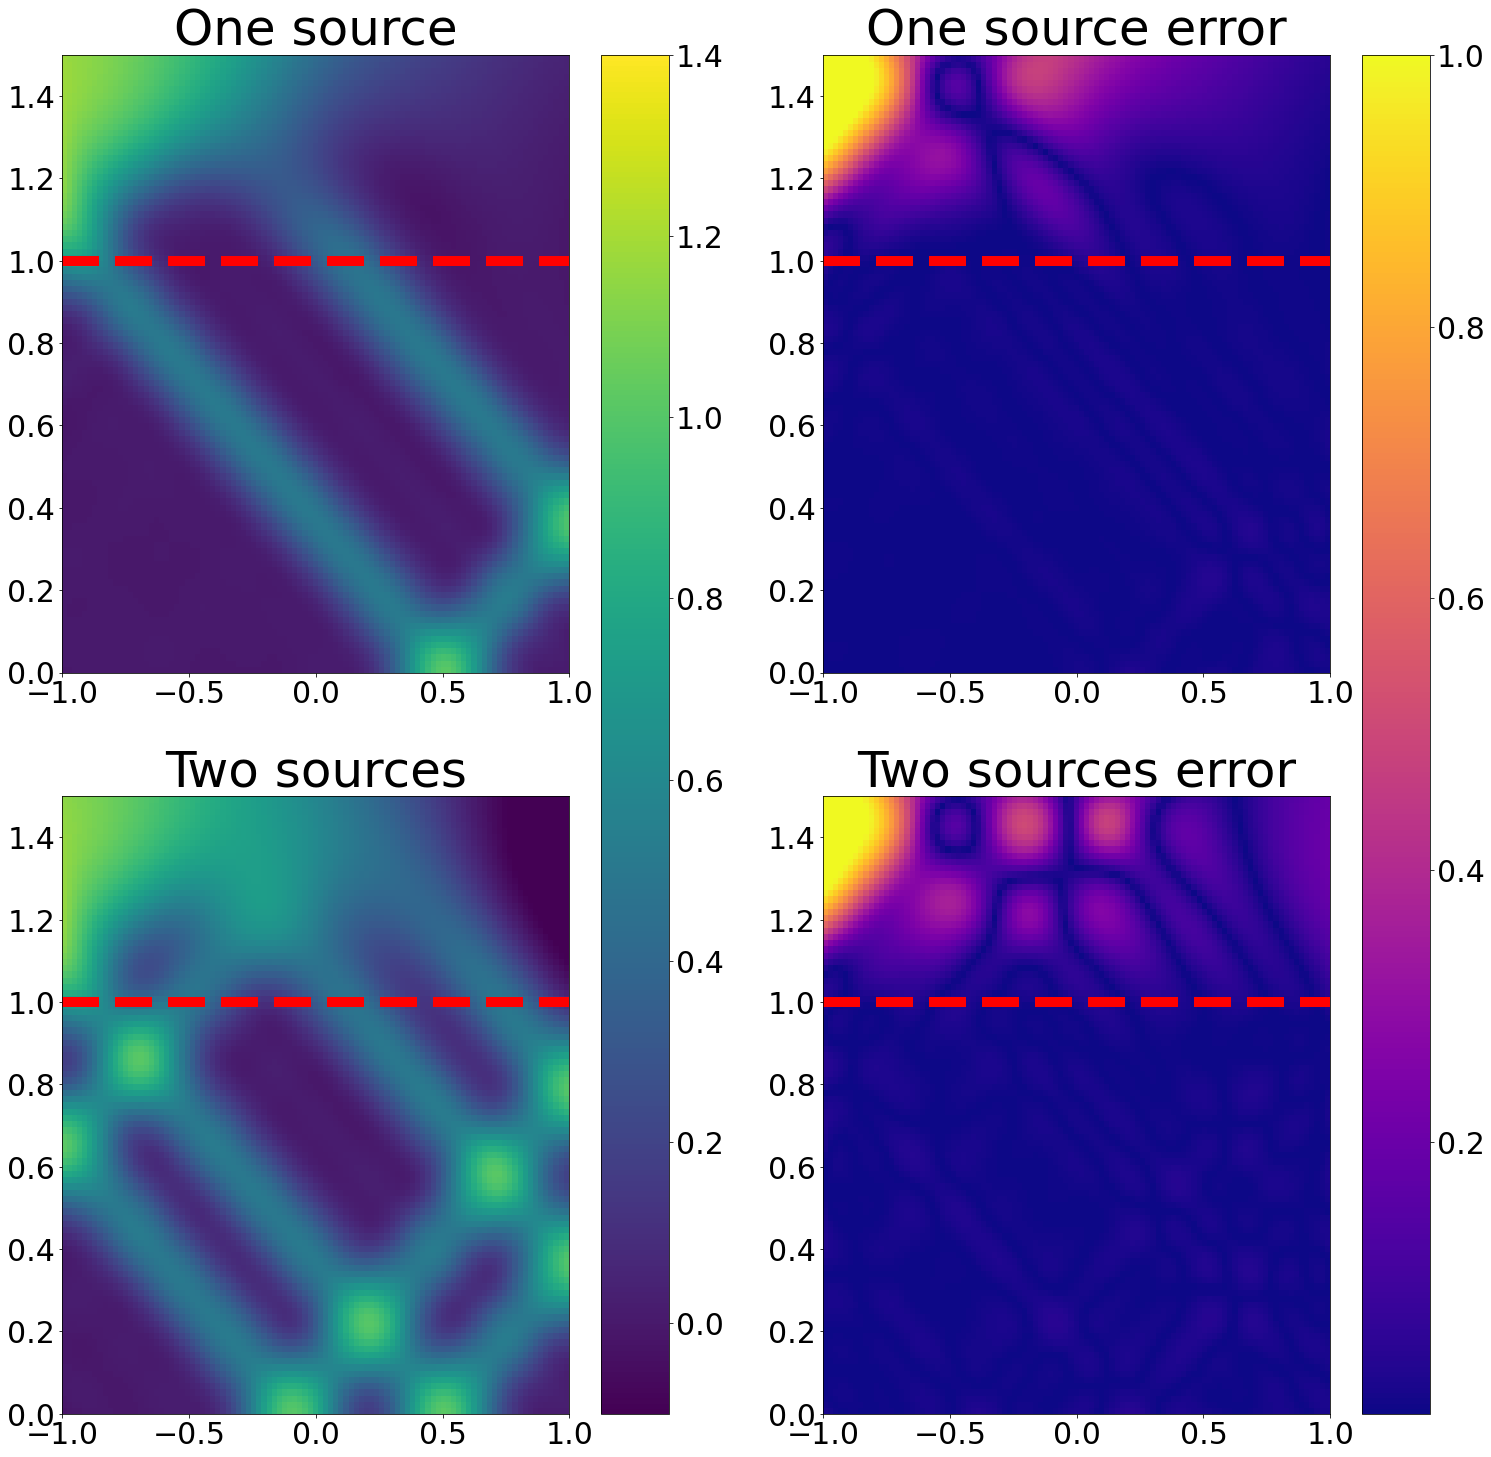

In [31]:
#Plotting output and error
fig, ax = plt.subplots(2,2, figsize=(25,25))

UU3=DeepOnet2(uu,Xtens,Ttens )
UU3=get_numpy(UU3).reshape(m,m)

UU4=DeepOnet2(uu2,Xtens,Ttens )
UU4=get_numpy(UU4).reshape(m,m)



p0=ax[0,0].pcolor(XX, TT, UU3,vmax=1.4,vmin=-0.1)
ax[0,0].plot([-1, 1], [1,1], 'r--', linewidth=10)
ax[0,0].set_title(r'One source', fontsize=50)
ax[0,0].tick_params(axis='both', which='major', labelsize=30)


p1=ax[1,0].pcolor(XX, TT, UU4,vmax=1.4,vmin=-0.1)
ax[1,0].plot([-1, 1], [1,1], 'r--', linewidth=10)
ax[1,0].set_title(r'Two sources', fontsize=50)
ax[1,0].tick_params(axis='both', which='major', labelsize=30)

p2=ax[0,1].pcolor(XX, TT, np.abs(UU3-true_solution(XX, TT,0.5,0.2,1.4)),vmax=1.0,cmap='plasma')
ax[0,1].plot([-1, 1], [1,1], 'r--', linewidth=10)
ax[0,1].set_title(r'One source error', fontsize=50)
ax[0,1].tick_params(axis='both', which='major', labelsize=30)

p3 = ax[1,1].pcolor(XX, TT, np.abs(UU4-(true_solution(XX, TT,0.5,0.2,1.4)+ true_solution(XX, TT,-0.1,0.2,1.4))),vmax=1.0,cmap='plasma')
ax[1,1].plot([-1, 1], [1,1], 'r--', linewidth=10)
ax[1,1].set_title(r'Two sources error', fontsize=50)
ax[1,1].tick_params(axis='both', which='major', labelsize=30)

c_ax1=fig.colorbar(p1,ax=ax[0:2,0])
c_ax3=fig.colorbar(p3,ax=ax[0:2,1])

ax[0,0].tick_params(axis='both', which='major', labelsize=30)
ax[1,0].tick_params(axis='both', which='major', labelsize=30)
ax[0,1].tick_params(axis='both', which='major', labelsize=30)
ax[1,1].tick_params(axis='both', which='major', labelsize=30)


c_ax1.ax.tick_params(labelsize=30)
c_ax3.ax.tick_params(labelsize=30)

plt.show()

fig.savefig("/content/gdrive/My Drive/DataDeep.png",transparent=True)


## Error

In [44]:
x=np.linspace(-1,1,m)
y=np.linspace(0,1,m)
ms_x, ms_y = np.meshgrid(x, y)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
y = np.ravel(ms_y).reshape(-1,1)

pt_x = Variable(torch.flatten(torch.from_numpy(x).float()), requires_grad=True).to(device)
pt_y = Variable(torch.flatten(torch.from_numpy(y).float()), requires_grad=True).to(device)
pt_u = torch.ravel(net(pt_x, pt_y))

u_temp = pt_u.data.cpu().numpy()
ms_u = u_temp.reshape(ms_x.shape)

pt_u2 = torch.ravel(net2(pt_x, pt_y))

u2_temp = pt_u2.data.cpu().numpy()
ms_u2 = u2_temp.reshape(ms_x.shape)

print("Max error PINN one and two sources")
print(np.max(abs(ms_u - true_solution(ms_x,ms_y,0.5,0.2,1.4))))
print(np.max(abs(ms_u2 - true_solution(ms_x,ms_y,0.5,0.2,1.4) - true_solution(ms_x,ms_y,-0.1,0.2,1.4))))



x=np.linspace(-1,1,m)
t=np.linspace(0,1,m)
uu=np.exp(-((x-0.5)/0.2)**2)

XX,TT=np.meshgrid(x,t)

Xtens=torch.tensor(np.float32(XX),device=device).reshape(-1)[:,None]
Ttens=torch.tensor(np.float32(TT),device=device).reshape(-1)[:,None]
 
uu=torch.tensor(np.float32(np.repeat(uu[:,None],m**2,1).T),device=device)
UU=DeepOnet(uu,Xtens,Ttens )
UU=get_numpy(UU).reshape(m,m)


uu2=np.exp(-((x+0.1)/0.2)**2)+np.exp(-((x-0.5)/0.2)**2)

uu2=torch.tensor(np.float32(np.repeat(uu2[:,None],m**2,1).T),device=device)
UU2=DeepOnet(uu2,Xtens,Ttens )
UU2=get_numpy(UU2).reshape(m,m)

UU3=DeepOnet2(uu,Xtens,Ttens )
UU3=get_numpy(UU3).reshape(m,m)

UU4=DeepOnet2(uu2,Xtens,Ttens )
UU4=get_numpy(UU4).reshape(m,m)


print("PI-DeepONet")
print(np.max(np.abs(UU-true_solution(XX, TT,0.5,0.2,1.4))))
print(np.max(np.abs(UU2-(true_solution(XX, TT,-0.1,0.2,1.4)+ true_solution(XX, TT,0.5,0.2,1.4)))))

print("Data DeepONet")
print(np.max(np.abs(UU3-+ true_solution(XX, TT,0.5,0.2,1.4))))
print(np.max(np.abs(UU4-(true_solution(XX, TT,-0.1,0.2,1.4)+ true_solution(XX, TT,0.5,0.2,1.4)))))

Max error PINN one and two sources
0.007299204337040954
0.006089289019712584
PI-DeepONet
0.04145960670634008
0.052430043773255
Data DeepONet
0.05237697740616448
0.048916374661813145


# Timing

In [52]:
t = time.time()
for i in range(1000):
  DeepOnet(uu,Xtens,Ttens)
elapsed = time.time() - t


x=JacobiGL(0,0,M);
u=np.exp(-((x-0.5)/0.2)**2)
t = time.time()
for i in range(1000):
  scipy.integrate.solve_ivp(fun, (0,1), np.concatenate([u,np.zeros(M+1)]), method='RK23')
elapsed2 = time.time() - t


print(elapsed/1000)
print(elapsed2/1000)

print(elapsed2/elapsed)


0.000807042121887207
0.12327643418312073
152.7509293998783


In [ ]:
#Numerical solver max error
Un=scipy.integrate.solve_ivp(fun, (0,1), np.concatenate([u,np.zeros(M+1)]), method='RK23')

xn,tn=np.meshgrid(x,Un.t)
print(np.max(np.abs(Un.y[:M+1,:].T-true_solution(xn, tn,0.5,0.2,1.4))))

0.0019304541362277093
